In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import shap
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from community import community_louvain
from textblob import TextBlob

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load dataset
try:
    df = pd.read_csv("fake_accounts_dataset.csv")
    edges = pd.read_csv("network_connections.csv")
    logging.info("Datasets loaded successfully.")
except FileNotFoundError as e:
    logging.error("File not found: %s", e)
    raise

2025-03-18 16:52:33,721 - INFO - Datasets loaded successfully.


In [21]:
# Data validation
if df.isnull().sum().sum() > 0:
    logging.warning("Dataset contains missing values. Consider imputing or removing them.")

def validate_columns(df, required_columns):
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        logging.error("Missing columns: %s", missing_columns)
        raise ValueError("Dataset is missing required columns.")

validate_columns(df, ['account_id', 'account_type', 'bio', 'followers', 'following', 'posts'])
validate_columns(edges, ['source', 'target'])

In [22]:
# Feature Engineering
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_features = vectorizer.fit_transform(df['bio'].fillna(""))
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())

scaler = StandardScaler()
numeric_features = df[['followers', 'following', 'posts']]
numeric_features_scaled = scaler.fit_transform(numeric_features)
numeric_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns)

In [23]:
# Sentiment Analysis
df['bio_sentiment'] = df['bio'].fillna("").apply(lambda x: TextBlob(x).sentiment.polarity)

In [24]:
# N-gram analysis
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=50)
ngram_features = count_vectorizer.fit_transform(df['bio'].fillna(""))
ngram_df = pd.DataFrame(ngram_features.toarray(), columns=count_vectorizer.get_feature_names_out())

final_df = pd.concat([numeric_df, tfidf_df, pd.DataFrame(df['bio_sentiment']), ngram_df], axis=1)
final_df['account_type'] = df['account_type']
final_df['account_id'] = df['account_id']

In [25]:
# Graph Analysis
graph = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.Graph())
communities = community_louvain.best_partition(graph)
betweenness = nx.betweenness_centrality(graph)
eigenvector = nx.eigenvector_centrality(graph, max_iter=1000)

community_series = pd.Series(communities, name='community')
betweenness_series = pd.Series(betweenness, name='betweenness')
eigenvector_series = pd.Series(eigenvector, name='eigenvector')

graph_features = pd.concat([community_series, betweenness_series, eigenvector_series], axis=1)
graph_features['account_id'] = graph_features.index

final_df = pd.merge(final_df, graph_features, on='account_id', how='left')
final_df = final_df.drop('account_id', axis=1)

In [26]:
# Train-Test Split
X = final_df.drop(columns=['account_type'])
y = final_df['account_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Handle missing values
imputer = SimpleImputer(strategy="mean")  # You can use "median" or "most_frequent" if needed
X_train = imputer.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [28]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Convert X_train to DataFrame if it's a NumPy array
X_train = pd.DataFrame(X_train)

# Drop rows with missing values
X_train.dropna(inplace=True)

# Ensure y_train matches X_train indices
y_train = y_train[:len(X_train)]

# Apply SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [29]:
# Model Training with Hyperparameter Tuning
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

C:\Users\chakr\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.98      0.82       281
           1       0.50      0.04      0.08       119

    accuracy                           0.70       400
   macro avg       0.60      0.51      0.45       400
weighted avg       0.65      0.70      0.60       400

Confusion Matrix:


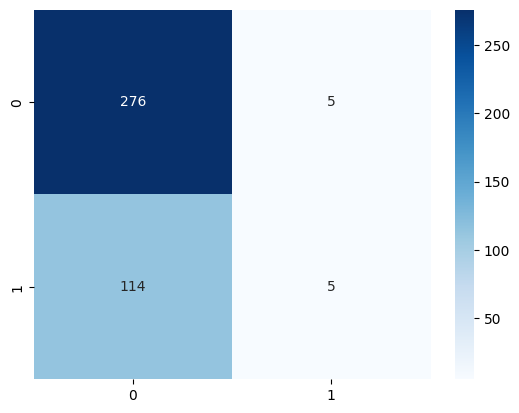

In [30]:
# Model Evaluation
y_pred = clf.best_estimator_.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

C:\Users\chakr\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC Score: 0.5223242321839767


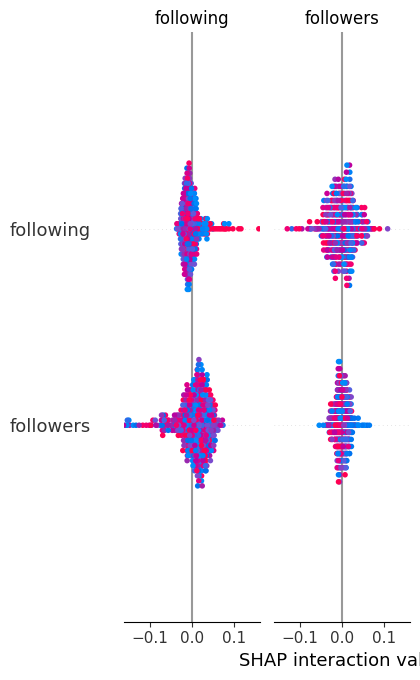

In [31]:
if len(y.unique()) == 2:
    print("ROC AUC Score:", roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1]))

# Explainability with SHAP
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

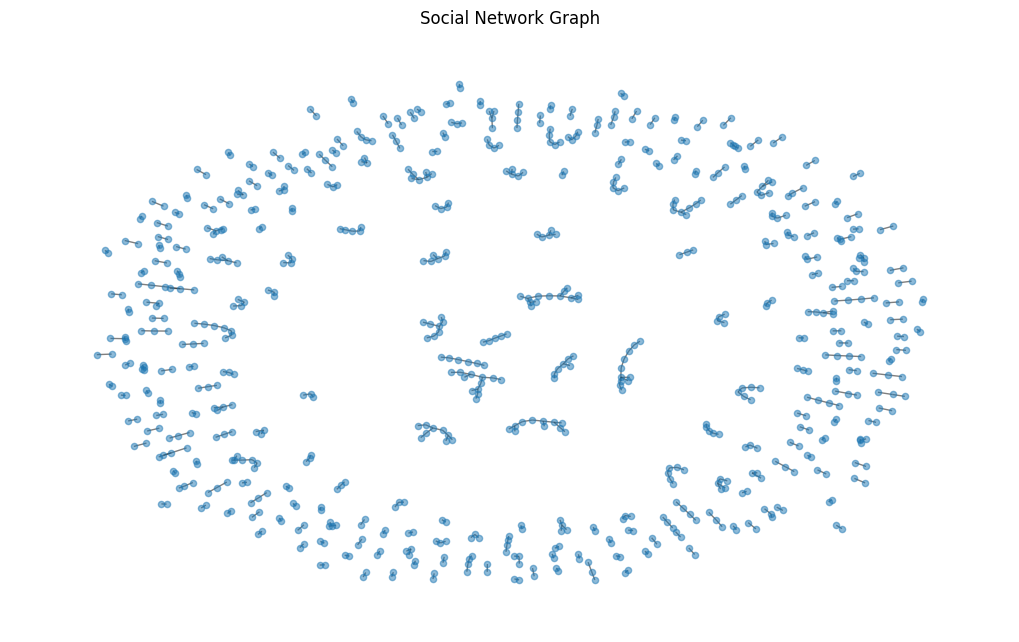

In [32]:
# Network Graph Visualization
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size=20, alpha=0.5)
plt.title("Social Network Graph")
plt.show()